# UFO 1 data analysis part 1

Big Data házi feladat, UFO1 feladatkör EDA analízise, adatfelderítése.

A használathoz feltételezzük, hogy már létezik egy állomány, data.csv néven, ami tartalmazza a szükséges adatokat.

Ennek a notebooknak a célja, hogy a letöltött adatokkal megismerkedjünk, néhány megfigyelést állapítsunk meg róluk, esetlegesen a nem megfelelő adatokat kiemeljük, és töröljük a készletből.


## Adatok betöltése, átalakítása

Az egyszerű betöltés után néhány kisebb módosítást végeztünk az adatokon:
* Date / Time osztlop átnevezése Date-re, az kezelhetőbbség kedvéért
* Shape oszlop értékei nem voltak konzisztensen kis vagy nagybetűsek, ezért ezeket egységesen csupa lowercase-re konvertáltuk
* A dátumok feldolgozásához a Python saját parser-ét használtuk
    * Amit az nem volt képes feldolgozni, azt egy nem előforduló értékre állítottuk, amit majd később ki lehet szűrni / el lehet dobni
    * Mivel az eredeti adatok szintaxisa miatt jövőbeni adatokat talált a parser, ezért ezeket kézzel módosítottuk

In [1]:
%matplotlib inline
import pandas
import matplotlib
import time
import random
import math
matplotlib.style.use("default")

In [2]:
start = time.time()

# Load data (labels are not included)
raw_data = pandas.read_csv("data.csv", sep=";", encoding="UTF8", header=None, skiprows=1)

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", \
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", \
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", \
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", \
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

data, wrong_data, skipped_lines = [], [], 0
for _, d in raw_data.iterrows():
    try:
        # Transform or validate data
        date = pandas.to_datetime(d[0])
        posted = pandas.to_datetime(d[6])
        state = d[2].upper() if d[2] is not pandas.np.NaN else d[2]
        shape = d[3].lower() if d[3] is not pandas.np.NaN else "unspecified"
        row = (date, d[1], state, shape, d[4], d[5], posted, d[7])
        
        # Do some checks...
        if date.date() > posted.date():
            wrong_data.append(row)
            continue
        
        if state not in states:
            wrong_data.append(row)
            continue
        
        # Add data to cleaned array
        data.append(row)
    except Exception as e:
        skipped_lines += 1

names = ["Date", "City", "State", "Shape", "Duration", "Summary", "Posted", "Description"]
data = pandas.DataFrame.from_records(data, columns=names)
wrong_data = pandas.DataFrame.from_records(wrong_data, columns=names)

print('Loading data took ' + str(time.time() - start) + 's')
print('Raw data: ' + str(len(raw_data)) + ' lines')
print('Processed data: ' + str(len(data)) + ' lines')
print('Skipped because of parser exception: ' + str(skipped_lines) + ' lines')
print('Wrong data: ' + str(len(wrong_data)) + ' lines')

Loading data took 82.94408464431763s
Raw data: 113241 lines
Processed data: 98303 lines
Skipped because of parser exception: 118 lines
Wrong data: 14820 lines


## Adatok feltérképezése

### Használt oszlopok és típusai, valamint néhány mintaadat

In [3]:
data.dtypes
sample_data = []
for i in range(10):
    sample_data.append(data.iloc[random.randint(0,len(data))])
pandas.DataFrame.from_records(sample_data, columns=names)

,Date,City,State,Shape,Duration,Summary,Posted,Description
0,2001-08-06 23:00:00,Portland,OR,sphere,15 min,slow moving bright red shere under low cloud d...,2001-08-12,NaN
1,2012-05-13 23:00:00,Seattle,WA,light,2 minutes,My room mate and I live on the fifth floor of ...,2012-05-29,NaN
2,2001-08-01 00:20:00,Evart,MI,fireball,7 - 9 seconds,Green fireball travelling south to north in m...,2001-08-05,NaN
3,2013-02-26 21:00:00,Columbia,MO,fireball,2-3 minutes,Single large fireball traveling SSE with no de...,2013-03-03,NaN
4,2012-02-05 20:35:00,Sayre,NY,light,25 minutes,Oddly bright flickering light on the horizon f...,2012-02-10,NaN
5,2007-06-07 22:00:00,Fresno,CA,triangle,6 min,brite ufos forming triangle pattern,2007-08-07,NaN
6,2000-09-02 14:00:00,Hebron,OH,light,app. 20 min.,erratic star-like light changes speed/direction,2005-09-15,NaN
7,2008-09-18 21:00:00,Jersey City,NJ,disk,10minutes,slow flying round shaped object with many ligh...,2008-10-31,NaN
8,2015-07-11 22:15:00,Oregonia,OH,sphere,3 minutes,"My wife, myself and my granddaughter witnessed...",2015-07-17,NaN
9,2017-02-20 20:00:00,Butte,MT,triangle,4 minutes,Walked out to smoke looked up. There was a tri...,2017-02-22,NaN


### Adatok vizualizációja az észlelés ideje alapján

count      52.000000
mean     1889.942308
std      2268.501167
min         1.000000
25%       234.250000
50%       318.500000
75%      3576.750000
max      8035.000000
Name: Date, dtype: float64


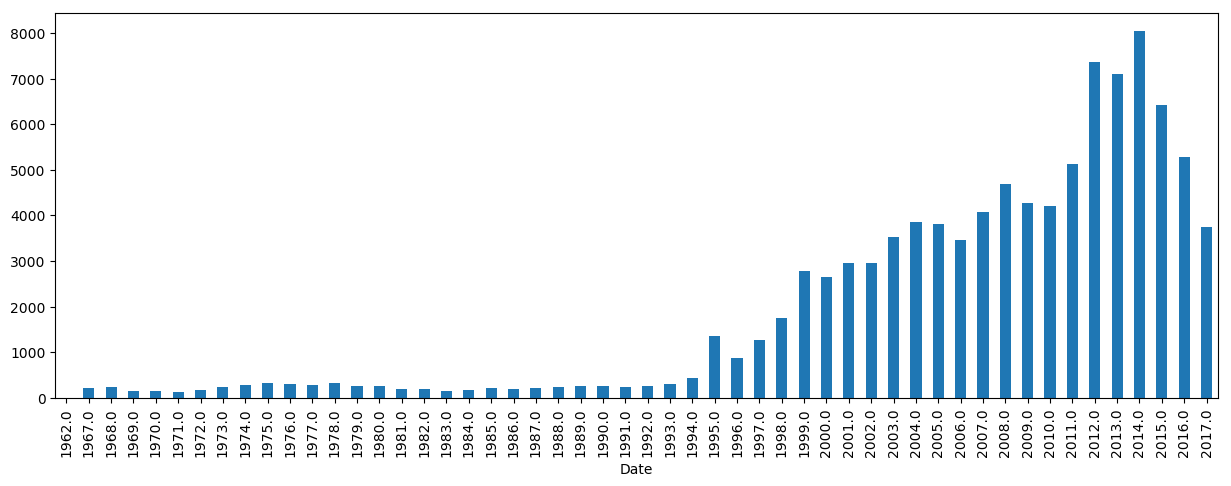

In [4]:
by_year = data.groupby(data["Date"].dt.year).count()["Date"]
print(by_year.describe())
data.groupby(data["Date"].dt.year).count()["Date"].plot(figsize=(15,5),kind="bar")

A vizualizációból látszik, hogy az adatok nagy része 2000 utánról származik.

### Adatok vizualizációja az észlelt ufók száma alapján, alak szerint csoportosítva

count       30.000000
mean      3276.766667
std       4418.705300
min          1.000000
25%         80.500000
50%       1574.500000
75%       5328.500000
max      20216.000000
Name: Shape, dtype: float64


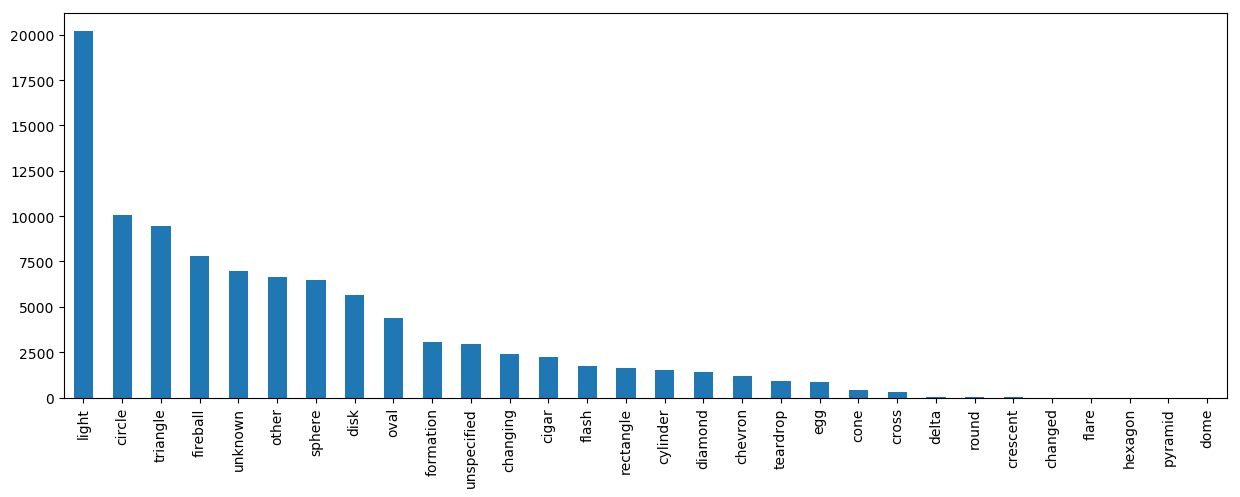

In [5]:
shape_counts = data["Shape"].value_counts()
print(shape_counts.describe())
shape_counts.plot(figsize=(15,5),kind="bar")

### Adatok leíró statisztikái a City és a State oszlop szerint

In [6]:
by_city = data.groupby("City").count()["Date"]
by_city.describe()

count    18562.000000
mean         5.289247
std         18.183232
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        643.000000
Name: Date, dtype: float64

Az adatok város szerinti vizsgálatából látszik, hogy nagyon sok különböző várost adtak meg az adathalmazban, amiből sok olyan van, ami vagy egyszeri észlelés, vagy ami valószínűbb, hogy valami elírás, vagy hibásan felvitt adat.

In [7]:
by_state = data.groupby("State").count()["Date"]
by_state.describe()

count       50.000000
mean      1965.540000
std       2083.079512
min        189.000000
25%        842.250000
50%       1324.000000
75%       2255.500000
max      12750.000000
Name: Date, dtype: float64

Az állam szerinti csoportosításnál úgy tűnik sikeres volt az adatok validációja és transzformációja, mert ezek szerint 1 kivételével mindegyik államból jelentettek észlelést. A qvartilisek, valamint a min és max értékek sem szembetűnően kiugróak a vártakhoz képest.

### Vizualizációs feladat megoldásának terve

A feladat szerint meg kell jelenítenünk az UFO észleléseket térbeli, és időbeli eloszlásuk szerint.
Erre megoldásnak az alábbi vizualizációt tervezzük megvalósítani:
* PySpark segítségével, Map - Reduce módszerrel elkészítjük az egyes évekhez tartozó megfigyelések számát, állam szerint
* Ezeket egy 2D pont diagrammon ábrázoljuk, X tengelyen az államokat, Y tengelyen az éveket.
* Ábrázolásnál az adatok számosságának jelölésére színeket és/vagy méreteket használunk.

A koncepciót az alábbi ábra szemlélteti:

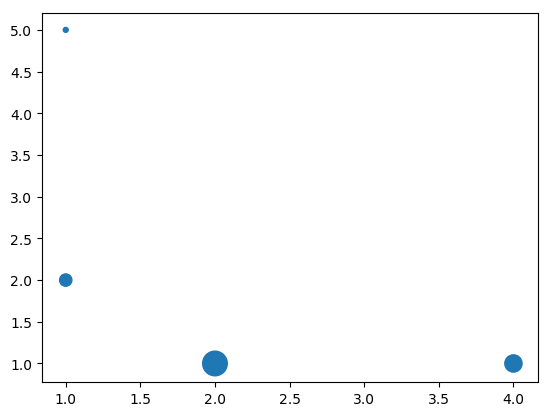

In [8]:
concept = [{"x":2,"y":1,"count":10},{"x":1,"y":2,"count":5},{"x":1,"y":5,"count":2},{"x":4,"y":1,"count":7}]
concept_df = pandas.DataFrame.from_records(concept)
matplotlib.pyplot.scatter(concept_df["x"],concept_df["y"],s=concept_df["count"]**2 * math.pi)
